In [1]:
import pyfolio as pf
import matplotlib.pyplot as plt
import pandas as pd
import backtrader as bt
import datetime
import quantstats as qs
import backtrader.indicators as btind

c:\Users\amrit\AppData\Local\Programs\Python\Python39\lib\site-packages\quantstats\stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)
c:\Users\amrit\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
c:\Users\amrit\AppData\Local\Programs\Python\Python39\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


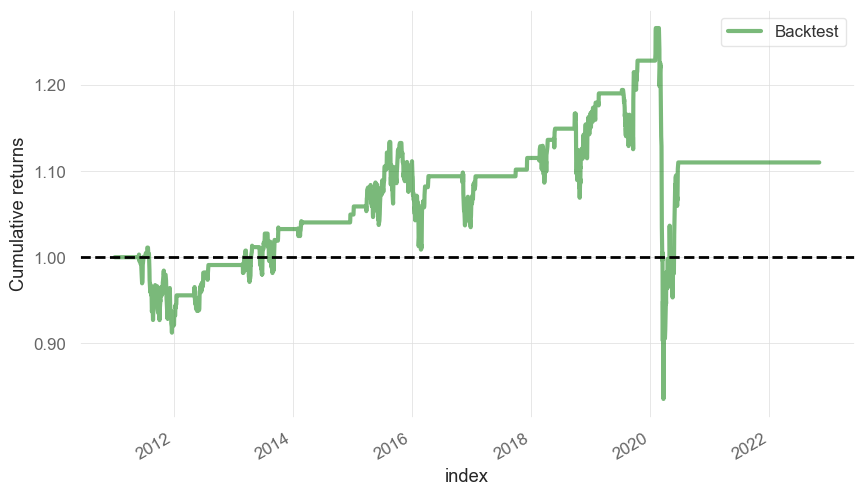

In [2]:
# Create a Stratey
class MeanReversion(bt.Strategy):
    params = (
        ('period', 100),
        ('deviation', 2),
        ('trail_percent', 0.03),
    )

    def __init__(self):
        self.sma = bt.indicators.SimpleMovingAverage(
            self.data.close, period=self.params.period
        )
        self.order = None
        self.stop_price = None

    def next(self):
        if not self.position:
            if self.data.close < self.sma[0] - self.params.deviation:
                self.order = self.buy()
                self.stop_price = self.data.close * (1 - self.params.trail_percent)
        else:
            if self.data.close > self.sma[0] + self.params.deviation:
                self.close()
                self.order = None
                self.stop_price = None
            elif self.data.close < self.stop_price:
                self.close()
                self.order = None
                self.stop_price = None
            else:
                self.stop_price = self.data.close * (1 - self.params.trail_percent)
                
cerebro = bt.Cerebro()

data = bt.feeds.YahooFinanceCSVData(
        dataname='../nifty_daily_continous.csv',
        # Do not pass values before this date
        fromdate=datetime.datetime(2011, 1, 3),
        # Do not pass values before this date
        todate=datetime.datetime(2022, 11, 7),
        # Do not pass values after this date
        reverse=False)

cerebro.adddata(data)
cerebro.addstrategy(MeanReversion)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')
results = cerebro.run()
strat = results[0]

portfolio_stats = strat.analyzers.getbyname('PyFolio')
returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
returns.index = returns.index.tz_convert(None)
qs.reports.html(returns, output='stats.html', title='Mean Reversal')

'''data = cerebro.plot()
data[0][0].savefig("mean_reversal.png")'''

# Plot the cumulative sum using Pyfolio
pf.plotting.plot_rolling_returns(returns)

## Monte Carlo Simulation

In [3]:
returns = pd.DataFrame({'datetime': returns.index, 'pnl': returns.values})

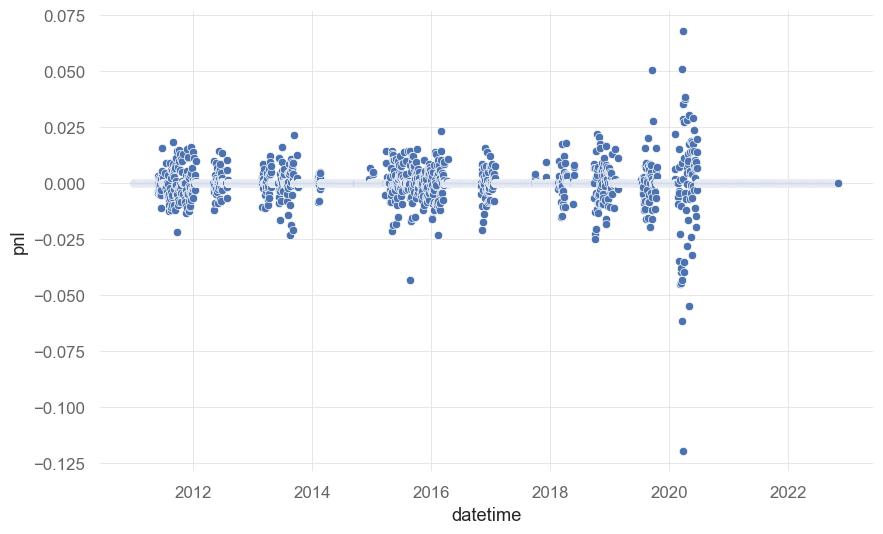

In [4]:
import seaborn as sns
sns.scatterplot(x=returns['datetime'], y=returns['pnl'])

In [5]:
def calc_max_dd(data_series):
    '''
    Inputs:
    data_series (pd.Series): A series of percentage returns of the strategy
    Returns:
    Maximum Drawdown (float)
    '''
    cumm_ret = data_series.cumsum()

    hwm = cumm_ret.cummax()
    dd = cumm_ret-hwm
    return round(dd.min(), 2)


In [6]:
def monte_carlo(simulations, df):
      mdd_list = []
      for s in range(simulations):
        mdd=0
        reshuffle=df['pnl'].sample(frac=1).reset_index(drop=True)
        plt.plot(reshuffle.cumsum())
        mdd=calc_max_dd(reshuffle)
        mdd_list.append(mdd)
      plt.plot(df['pnl'].cumsum(),linewidth=3,color='black')
      plt.xlabel('Trade No.')
      plt.ylabel('Cummulative Returns')
      plt.title('Monte Carlo Simulation for {} Simulations'.format(simulations))
      plt.show()
      return mdd_list

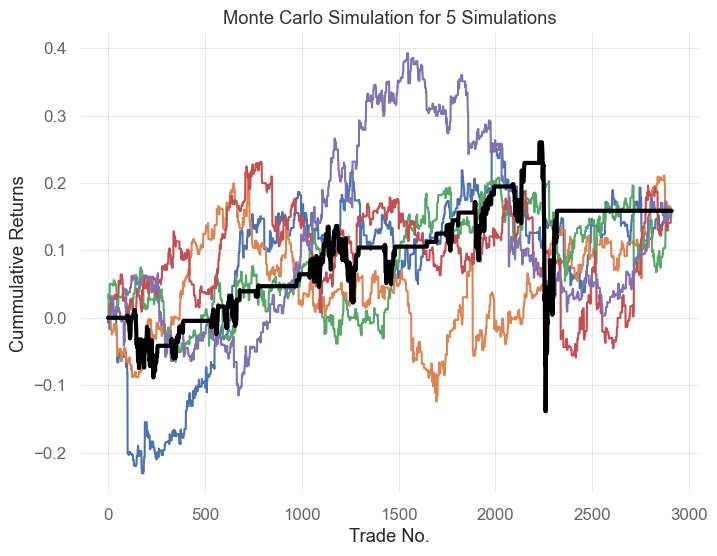

In [7]:
simulations = 5
plt.figure(figsize=(8, 6))
mdd_list = monte_carlo(simulations, returns)

In [8]:
mdd_list

[-0.24, -0.33, -0.17, -0.29, -0.39]

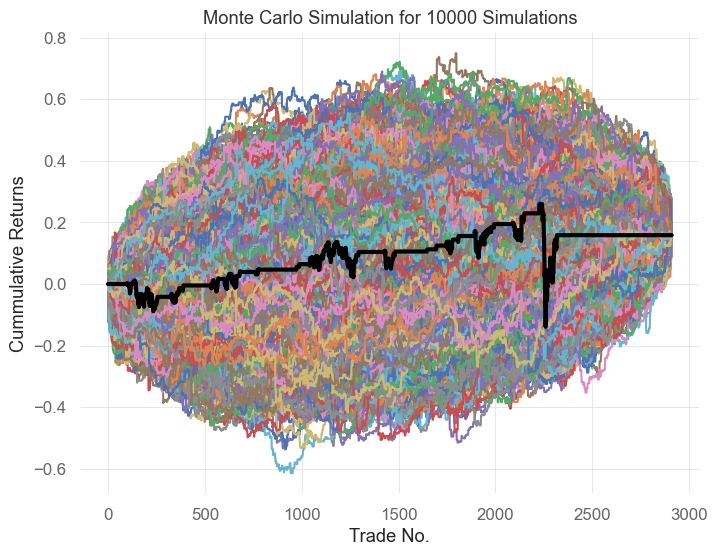

In [9]:
simulations = 10000
plt.figure(figsize=(8, 6))
mdd_list = monte_carlo(simulations, returns)

In [10]:
df_mdd = pd.DataFrame(mdd_list, columns=['Max DD'])

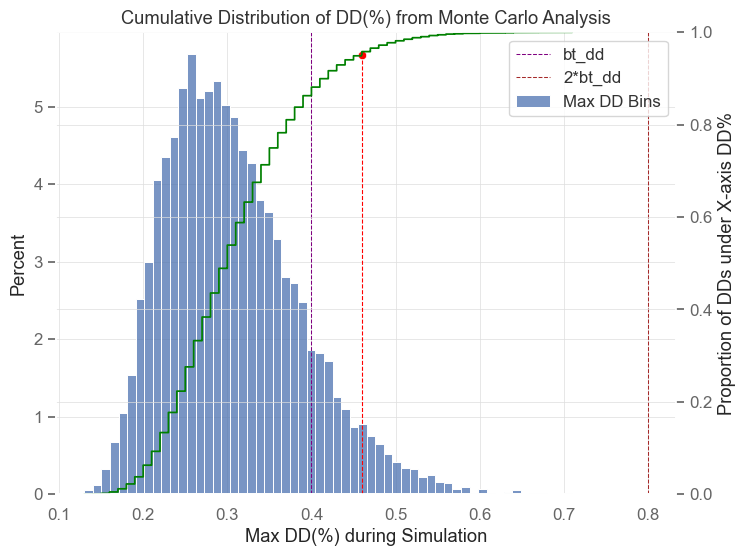

Backtest Drawdown: -0.4% , The 95.0 percentile of the Drawdown based on Monte Carlo is:0.46%


In [11]:
import numpy as np
n_tile = 0.95  # Cut-Off Percentile to plot
n_tile_value = np.round(df_mdd['Max DD'].quantile(q=1-n_tile), 2)
bt_dd = calc_max_dd(returns['pnl'])
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.histplot(ax=ax, x=-1*df_mdd['Max DD'], stat='percent')  # ,cumulative=True)
ax.set_title('Cumulative Distribution of DD(%) from Monte Carlo Analysis')
ax.set_xlabel('Max DD(%) during Simulation')
ax.axvline(-bt_dd, ymax=1, color='purple', linestyle='dashed', linewidth=0.75)
ax.axvline(-2*bt_dd, ymax=1, color='brown', linestyle='dashed', linewidth=0.75)
ax.legend(labels=['bt_dd', '2*bt_dd', 'Max DD Bins'])
ax2 = ax.twinx()
sns.ecdfplot(ax=ax2, x=-1*df_mdd['Max DD'], color='green', linewidth=1.25)
sns.scatterplot(x=[-1*n_tile_value], y=[n_tile], ax=ax2, color='red')
ax2.axvline(-1*n_tile_value, ymax=n_tile, color='red',
            linestyle='dashed', linewidth=0.8)
ax2.set_ylabel('Proportion of DDs under X-axis DD%')
plt.show()
print(
    f'Backtest Drawdown: {bt_dd}% , The {n_tile*100} percentile of the Drawdown based on Monte Carlo is:{-1*n_tile_value}%')